In [26]:
import pandas as pd

### Data Loading

In [27]:
dfList = []
for i in range(1,32):
    print(".",end='', flush=True)
    dfList.append(pd.read_json("./data/fraud-data/2017-01-{0:02d}.txt".format(i), lines=True))
print("done!")
df = pd.concat(dfList)

...............................done!


In [28]:
print(df.fraudLabel.value_counts())
df.head()

0    30075
1      925
Name: fraudLabel, dtype: int64


,basket,customerID,fraudLabel,totalAmount,zipCode
0,"[1, 0, 3, 2, 3, 0, 3]",3479993074,0,287,25378
1,"[0, 4, 2]",9867234339,0,30,63929
2,[4],9722892914,0,75,97373
3,"[0, 2, 3, 0, 1, 3]",3473098263,0,732,95113
4,"[1, 4, 3]",5789310347,1,390,84278


### Feature Engineering

In [29]:
df['c_0'] = df.basket.map(lambda x: x.count(0))
df['c_1'] = df.basket.map(lambda x: x.count(1))
df['c_2'] = df.basket.map(lambda x: x.count(2))
df['c_3'] = df.basket.map(lambda x: x.count(3))
df['c_4'] = df.basket.map(lambda x: x.count(4))

In [30]:
df.head()

,basket,customerID,fraudLabel,totalAmount,zipCode,c_0,c_1,c_2,c_3,c_4
0,"[1, 0, 3, 2, 3, 0, 3]",3479993074,0,287,25378,2,1,1,3,0
1,"[0, 4, 2]",9867234339,0,30,63929,1,0,1,0,1
2,[4],9722892914,0,75,97373,0,0,0,0,1
3,"[0, 2, 3, 0, 1, 3]",3473098263,0,732,95113,2,1,1,2,0
4,"[1, 4, 3]",5789310347,1,390,84278,0,1,0,1,1


In [31]:
%%script false
#df["zipCode"] = df["zipCode"].astype('category',categories=[i for i in list(range(10000,100000))])
dummies = pd.get_dummies(df.zipCode)

In [32]:
%%script false
dummies.head()

In [33]:
#df2 = pd.concat([df, dummies], axis=1)
df2 = pd.concat([df], axis=1)

In [34]:
#df3 = df2.drop(["basket", "zipCode", "customerID"], axis=1)
df3 = df2.drop(["basket", "customerID"], axis=1)

In [35]:
df3.head()

,fraudLabel,totalAmount,zipCode,c_0,c_1,c_2,c_3,c_4
0,0,287,25378,2,1,1,3,0
1,0,30,63929,1,0,1,0,1
2,0,75,97373,0,0,0,0,1
3,0,732,95113,2,1,1,2,0
4,1,390,84278,0,1,0,1,1


### Model training

In [43]:
train, test = sk.model_selection.train_test_split(df3, test_size=0.3, random_state=0)
train.head()

,fraudLabel,totalAmount,zipCode,c_0,c_1,c_2,c_3,c_4
281,0,1248,27552,1,2,2,5,2
57,0,120,15856,0,1,3,0,1
273,0,130,65290,0,0,3,1,1
725,0,146,25083,0,1,0,1,0
55,1,116,96166,0,0,0,2,0


Save to csv

In [44]:
%%script false
# save predictions to csv
train.to_pickle("./data/train.pickle")
test.to_pickle("./data/test.pickle")

Create X and y

In [46]:
X_train = train[train.columns[1:]]
y_train = train["fraudLabel"]
X_test = test[test.columns[1:]]
y_test = test["fraudLabel"]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21700, 7) (21700,) (9300, 7) (9300,)


In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()
gbt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Model evaluation

In [15]:
test_scores_reg = logreg.predict_proba(X_test)
test_scores_gbt = gbt.predict_proba(X_test)

In [17]:
from sklearn import metrics
fpr_reg, tpr_reg, _ =  sk.metrics.roc_curve(y_test, test_scores_reg[:,1])
auc_reg = metrics.auc(fpr_reg, tpr_reg)
fpr_gbt, tpr_gbt, _ =  sk.metrics.roc_curve(y_test, test_scores_gbt[:,1])
auc_gbt = metrics.auc(fpr_gbt, tpr_gbt)

In [18]:
# save predictions to csv
df = pd.DataFrame(data={'label': y_test, 'predReg': test_scores_reg[:,1], 
                  'predGbt': test_scores_gbt[:,1] })
df.to_csv("./data/predictions.csv", index=False)

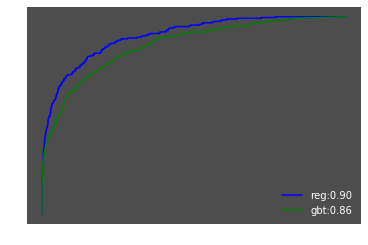

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_reg, tpr_reg, color = 'blue', label = "reg:{:.2f}".format(auc_reg))
plt.plot(fpr_gbt, tpr_gbt, color = 'green', label = "gbt:{:.2f}".format(auc_gbt))
plt.legend()
plt.grid()
plt.show()

### Save predictions on train data for modelCalibration

In [20]:
train_scores_reg = logreg.predict_proba(X_train)
train_scores_gbt = gbt.predict_proba(X_train)

In [21]:
# save predictions to csv
df = pd.DataFrame(data={'label': y_train, 'predReg': train_scores_reg[:,1], 
                  'predGbt': train_scores_gbt[:,1] })
#df.to_csv("./data/predictions_train.csv", index=False)